<a href="https://colab.research.google.com/github/ibnu666-beep/PBO_TIsem3_dvibnu/blob/main/Praktikum03_Teknik_Regresi_Gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**PRAKTIKUM D1**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models

def make_sample(img_size=64, min_r=5, max_r=20):
  r = np.random.randint(min_r, max_r +1)
  img = np.zeros((img_size, img_size), dtype=np.uint8)
  cx = np.random.randint(r, img_size - r)
  cy = np.random.randint(r, img_size - r)
  cv2.circle(img, (cx, cy), r, (255,), -1)
  img = (img / 255.0).astype(np.float32)

  img3 = np.stack([img, img, img], axis=-1)
  return img3, float(r), (cx, cy)

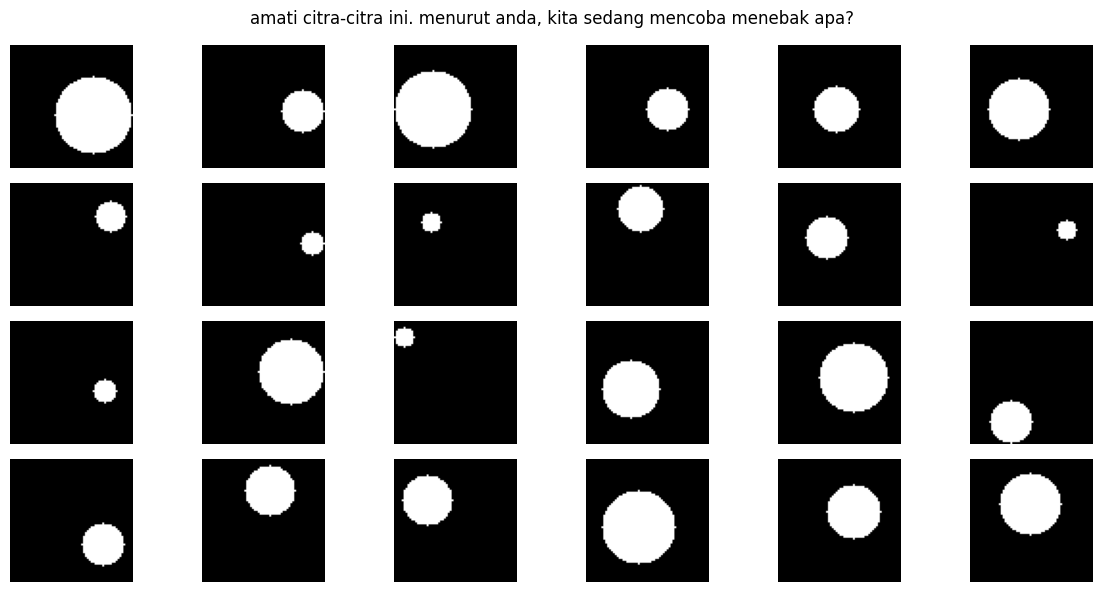

In [ ]:
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

cols = 6
rows = N_show // cols
plt.figure(figsize=(12, 6))
for i in range(N_show):
  plt.subplot(rows, cols, i+1)
  plt.imshow(imgs[i].squeeze(), cmap='gray')
  plt.axis('off')
plt.suptitle("amati citra-citra ini. menurut anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()

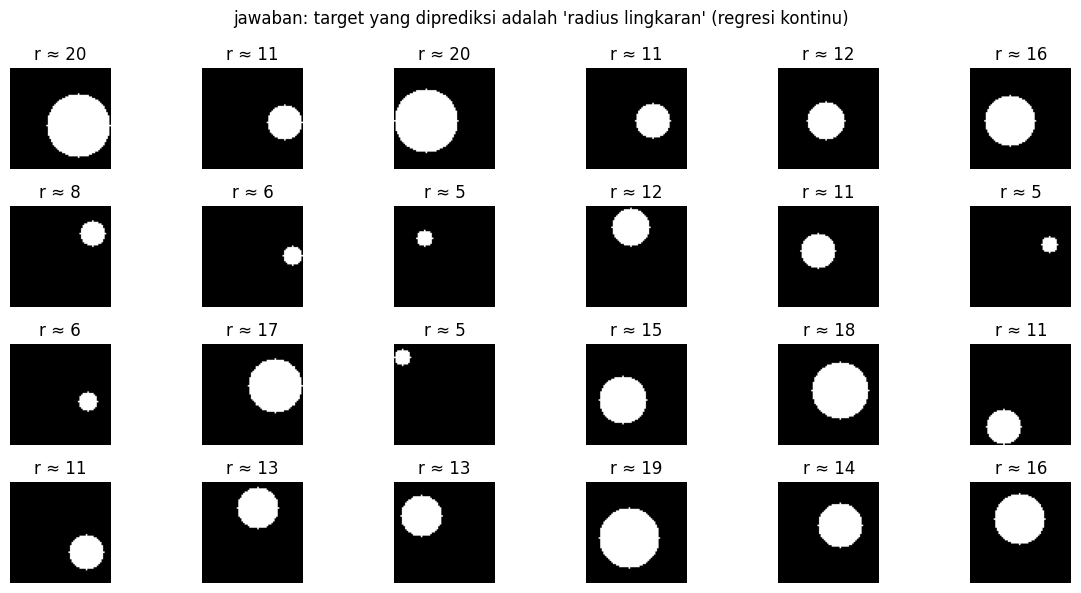

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(N_show):
  plt.subplot(rows, cols, i+1)
  plt.imshow(imgs[i] .squeeze(), cmap='gray')
  plt.title(f"r ≈ {int(rads[i])}")
  plt.axis('off')
plt.suptitle("jawaban: target yang diprediksi adalah 'radius lingkaran' (regresi kontinu)")
plt.tight_layout()
plt.show()

In [ ]:
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

model = models.Sequential([
    layers.Input((64,64,3)),
    layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'), layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
    ])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(Xtr, ytr, validation_data=(Xte, yte), epochs=12, batch_size=64, verbose=0)

y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred) **2)))
r2 = r2_score(yte, y_pred)
print(f"MAE={mae:.3f}  |  RMSE={rmse:.3f}  |  R2={r2:.3f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
MAE=1.045  |  RMSE=1.276  |  R2=0.921


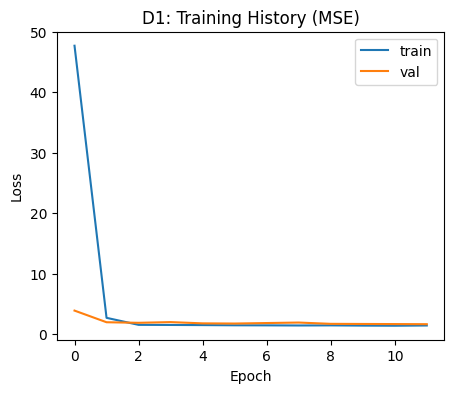

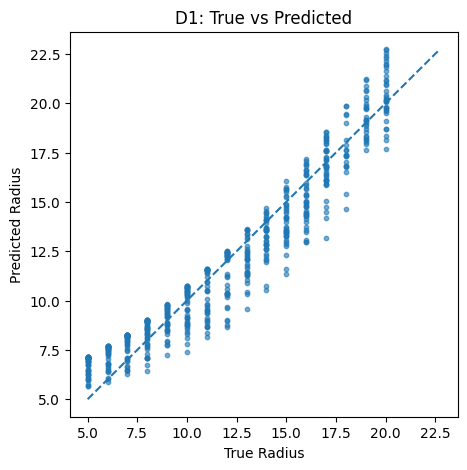

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius"); plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()

#**PRAKTIKUM D2**

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dvibnu","key":"4c9f76654558910a62d2709709d7bbf8"}'}

In [3]:
import os, shutil
if os.path.exists("kaggle.json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
  os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
  !pip install kaggle
  print("Kagglle API siap digunakan")
else:
  print("kaggle.json belum ditemukan. upload terlebih dahulu")

Kagglle API siap digunakan


In [4]:
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("dataset utkface berhasil diekstrak")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
dataset utkface berhasil diekstrak


crop_part1
UTKFace
utkface_aligned_cropped
total gambar ditemukan: 23708


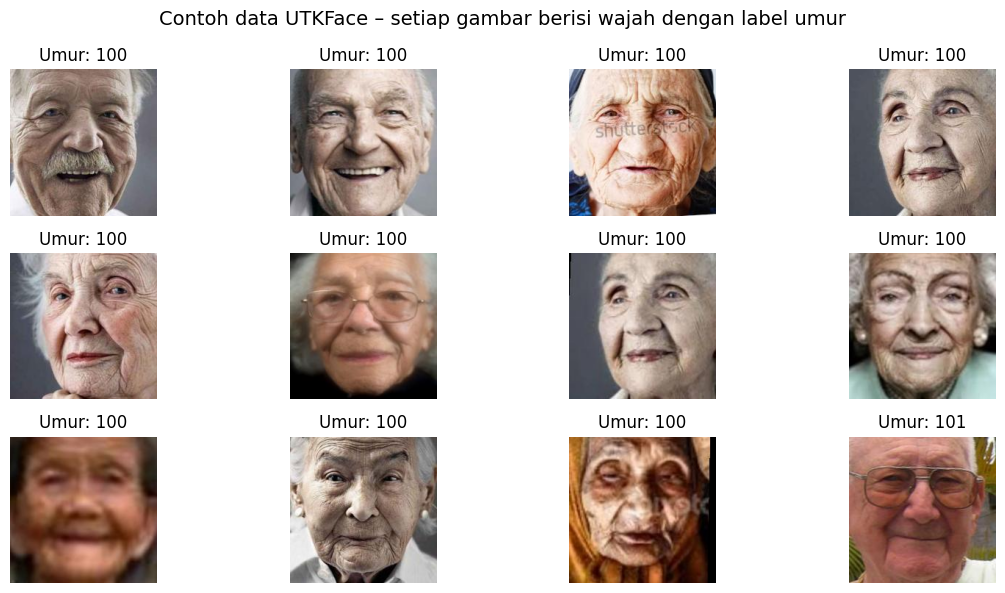

In [5]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

!ls /content/utk | head  # cek isi folder utk

files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"total gambar ditemukan: {len(files)}")

plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
    age = int(os.path.basename(f).split("_")[0])
    img = Image.open(f)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Umur: {age}")
    plt.axis("off")

plt.suptitle("Contoh data UTKFace – setiap gambar berisi wajah dengan label umur", fontsize=14)
plt.tight_layout()
plt.show()

In [6]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
  return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(files, ages, test_size=0.2, random_state=42)

IMG_SIZE = 160
def load_img(fp, label):
  img = tf.io.read_file(fp)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
  return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)) .map(load_img) .batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)) .map(load_img) .batch(64)

print("dataset siap dilatih.")

dataset siap dilatih.


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

print("hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

IMG_SIZE = 160

base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='mse',
              metrics=['mae'])

model.summary()

hardware: GPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 60s 146ms/step - loss: 343.4431 - mae: 13.6293 - val_loss: 159.8600 - val_mae: 9.6596 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 155.2538 - mae: 9.2786 - val_loss: 148.6277 - val_mae: 9.2219 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 145.4950 - mae: 8.9371 - val_loss: 142.6702 - val_mae: 8.9574 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 139.8276 - mae: 8.6868 - val_loss: 140.2948 - val_mae: 8.8380 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 137.3034 - mae: 8.6162 - val_loss: 137.7335 - val_mae: 8.7524 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 135.8432 - mae: 8.5672 - val_loss: 133.8853 - val_mae: 8.5515 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 131.4313 - mae: 8.4032 - val_loss: 134.2088 - va

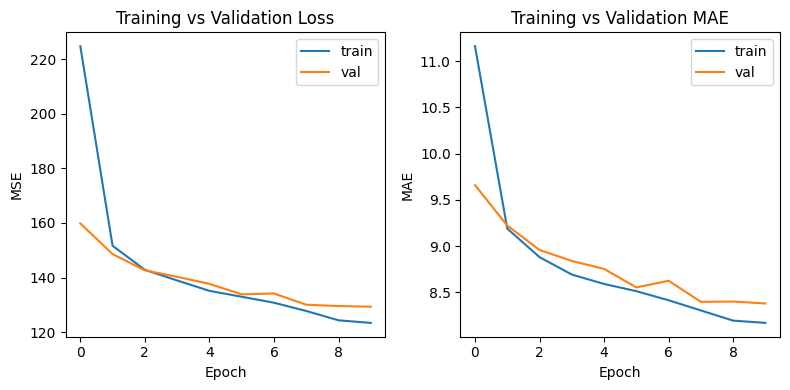

In [8]:
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 44s 97ms/step - loss: 191.2185 - mae: 10.2011 - val_loss: 148.1166 - val_mae: 9.3323 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 78.2450 - mae: 6.6075 - val_loss: 126.4064 - val_mae: 8.6170 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - loss: 51.5772 - mae: 5.4404 - val_loss: 104.3673 - val_mae: 7.6331 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 37.9442 - mae: 4.7193 - val_loss: 113.4310 - val_mae: 8.1563 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 29.9987 - mae: 4.1690 - val_loss: 109.3206 - val_mae: 7.8299 - learning_rate: 1.0000e-04


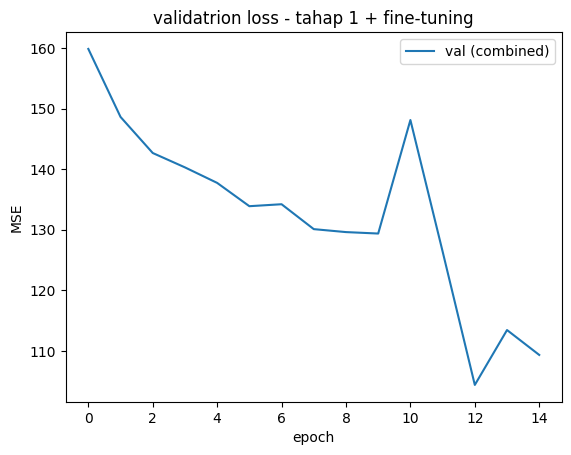

In [9]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
  layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='mse', metrics=['mae'])

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

plt.plot(history.history['val_loss'] + history_ft.history['val_loss'],
         label='val (combined)')
plt.title("validatrion loss - tahap 1 + fine-tuning")
plt.xlabel("epoch"); plt.ylabel("MSE")
plt.legend(); plt.show()

MAE = 7.63 tahun
RMSE = 10.22 tahun
R2 = 0.737


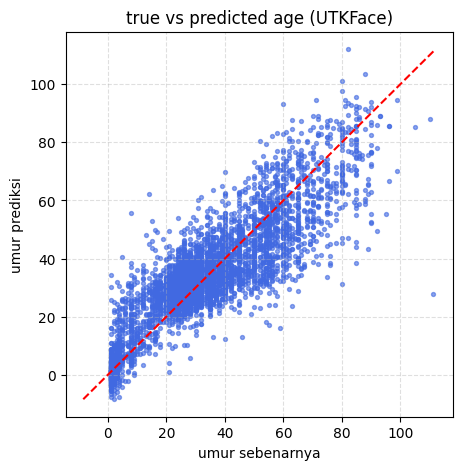

In [10]:
from math import sqrt

y_pred = np.concatenate([model.predict(batch[0], verbose=0) .ravel() for batch in test_ds])
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R2 = {r2:.3f}")

plt.figure(figsize=(5,5,))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [
    min(y_test.min(), y_pred.min()),
    max(y_test.max(), y_pred.max())
]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("umur sebenarnya")
plt.ylabel("umur prediksi")
plt.title("true vs predicted age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

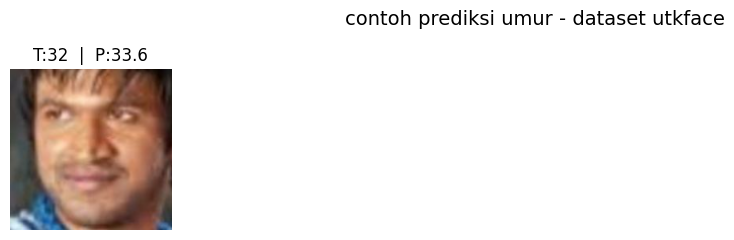

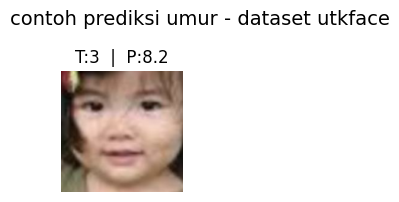

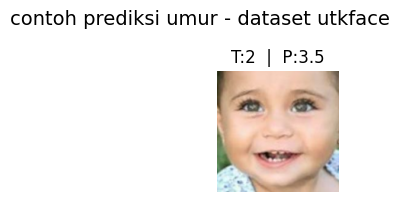

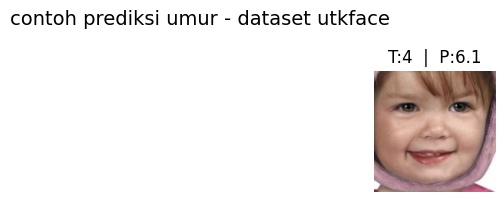

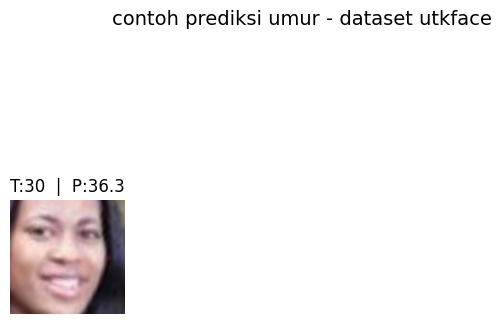

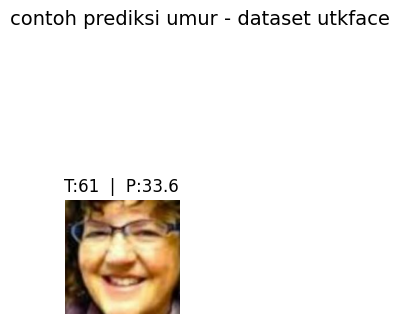

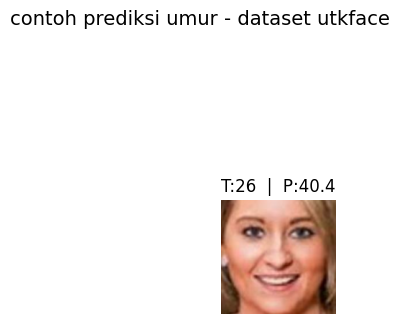

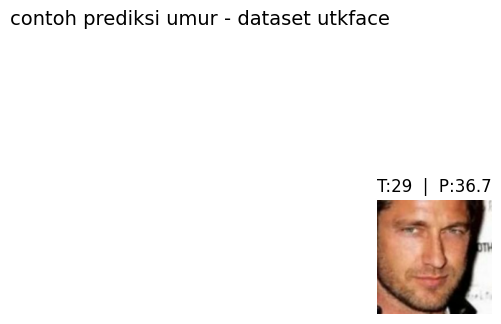

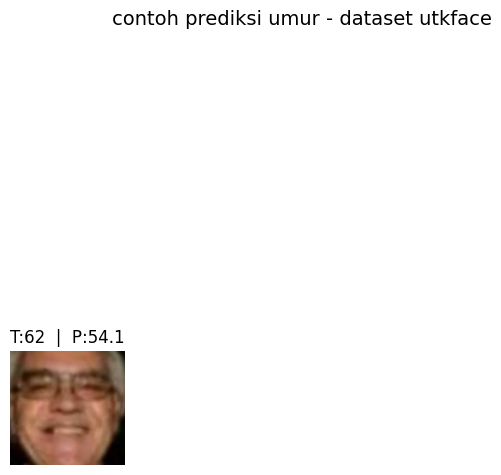

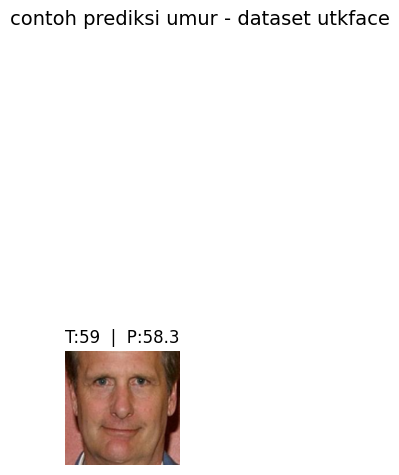

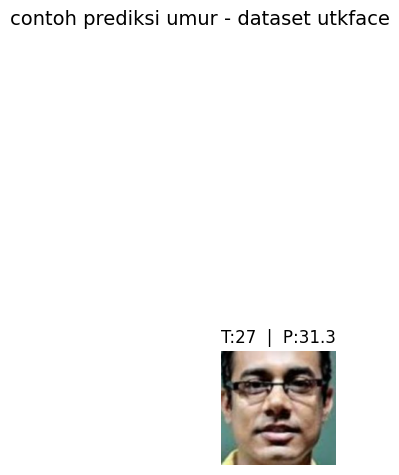

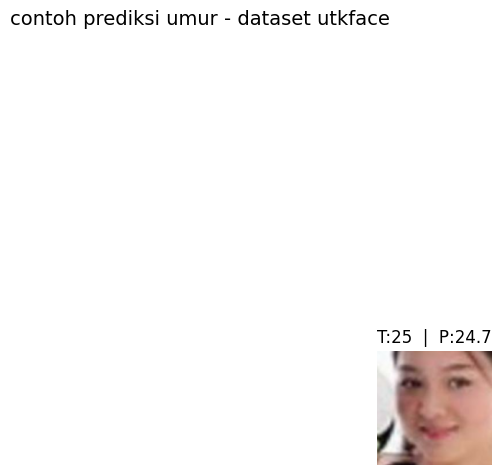

In [11]:
import random
sample_paths = random.sample(test_files, 12)

plt.figure(figsize=(12,6))
for i, path in enumerate(sample_paths):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
  true_age = int(os.path.basename(path).split('_')[0])
  pred_age = model.predict(tf.expand_dims(img, 0), verbose=0) .ravel() [0]
  plt.subplot(3,4,i+1)
  plt.imshow(img.numpy())
  plt.title(f"T:{true_age}  |  P:{pred_age:.1f}")
  plt.axis('off')
  plt.suptitle("contoh prediksi umur - dataset utkface", fontsize=14)
  plt.tight_layout()
  plt.show()

Silakan unggah foto wajah Anda untuk diprediksi usianya.


Saving IMG20250425120810.jpg to IMG20250425120810.jpg

✅ Foto 'IMG20250425120810.jpg' berhasil diunggah.


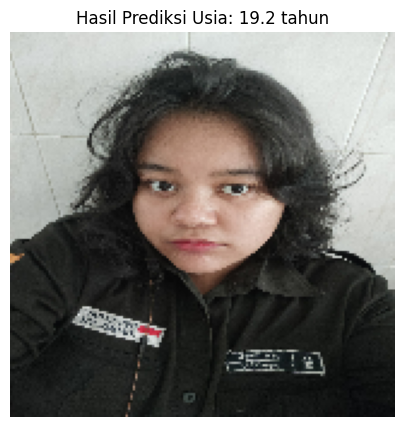

In [12]:
# Import library yang dibutuhkan
from google.colab import files
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# --- FUNGSI UNTUK MEMPROSES DAN MEMPREDIKSI GAMBAR ---
def prediksi_umur_foto_pribadi(model_umur):
    """
    Fungsi untuk mengunggah foto, memprosesnya, dan memprediksi usia.
    """
    # 1. Mengunggah file dari komputer Anda
    uploaded = files.upload()

    # Ambil nama file yang diunggah
    if not uploaded:
        print("Tidak ada file yang diunggah. Silakan coba lagi.")
        return

    nama_file = list(uploaded.keys())[0]
    print(f"\n✅ Foto '{nama_file}' berhasil diunggah.")

    # 2. Membaca dan memproses gambar
    IMG_SIZE = 160 # Sesuaikan dengan ukuran input model di Praktikum D2

    # Baca file gambar
    img = tf.io.read_file(nama_file)
    img = tf.image.decode_jpeg(img, channels=3)

    # Ubah ukuran dan normalisasi gambar
    img_processed = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0

    # Tambahkan dimensi batch (karena model menerima input dalam batch)
    img_batch = tf.expand_dims(img_processed, 0)

    # 3. Lakukan prediksi
    prediksi = model_umur.predict(img_batch, verbose=0)
    prediksi_umur = prediksi.ravel()[0] # Ambil nilai prediksi

    # 4. Tampilkan hasilnya
    plt.figure(figsize=(5, 5))
    plt.imshow(img_processed)
    plt.title(f"Hasil Prediksi Usia: {prediksi_umur:.1f} tahun")
    plt.axis('off')
    plt.show()

    # Hapus file yang diunggah agar tidak menumpuk
    os.remove(nama_file)

# --- JALANKAN PREDIKSI ---
# Pastikan variabel `model` dari Praktikum D2 sudah ada dan telah dilatih.
# Jika Anda menamainya lain, silakan ganti `model` di bawah ini.
print("Silakan unggah foto wajah Anda untuk diprediksi usianya.")
prediksi_umur_foto_pribadi(model) # Menggunakan variabel 'model' dari D2

#**PRAKTIKUM D3**

In [1]:
from google.colab import files
files.upload()
import os, shutil
if os.path.exists("kaggle.json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
  os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
  !pip -q install kaggle
  print(" kaggle API siap digunakan ")
else:
  print("kaggle.json belum ditemukan. upload terlebih dahulu")

Saving kaggle.json to kaggle.json
 kaggle API siap digunakan 


In [2]:
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("dataset pawpularity berhasil diekstrak")

dataset pawpularity berhasil diekstrak


                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

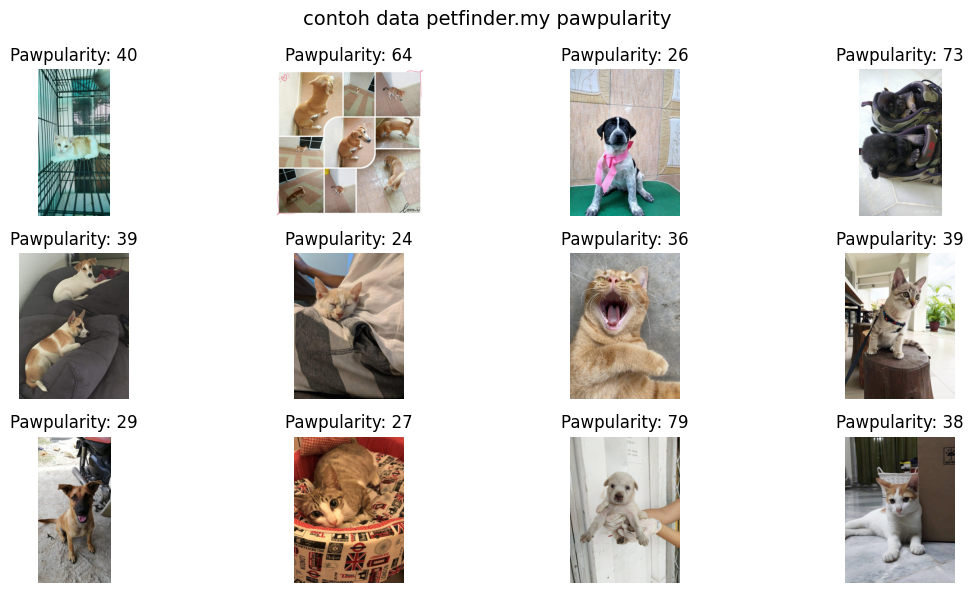

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
  img = Image.open(row.path)
  plt.subplot(3, 4, i+1)
  plt.imshow(img)
  plt.title(f"Pawpularity: {row.Pawpularity}")
  plt.axis('off')
plt.suptitle("contoh data petfinder.my pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def load_image(path, label):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
  img = tf.cast(img, tf.float32) / 255.0
  return img, tf.cast(label, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'], train_df['Pawpularity']))\
.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
.shuffle(4096) .batch(64) .prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'], val_df['Pawpularity']))\
.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
.batch(64) .prefetch(tf.data.AUTOTUNE)

print(f"dataset siap digunakan - {len(train_df)} untuk training, {len(val_df)} untuk validasi")

dataset siap digunakan - 7929 untuk training, 1983 untuk validasi


In [6]:
from tensorflow.keras import layers, models

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dropout(0.3) (x)
x = layers.Dense(256, activation='relu') (x)
outputs = layers.Dense(1) (x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [7]:
cb = [
tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=cb, verbose=1)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 102s 490ms/step - loss: 857.6030 - mae: 22.1036 - val_loss: 485.3589 - val_mae: 16.0846 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 199ms/step - loss: 433.6074 - mae: 15.3655 - val_loss: 441.2210 - val_mae: 15.7992 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 39s 192ms/step - loss: 397.3886 - mae: 14.7686 - val_loss: 409.3683 - val_mae: 14.9863 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 43s 200ms/step - loss: 366.0069 - mae: 14.1654 - val_loss: 396.8055 - val_mae: 14.8087 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 36s 197ms/step - loss: 364.6042 - mae: 14.1757 - val_loss: 385.6712 - val_mae: 14.4148 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 40s 227ms/step - loss: 360.2602 - mae: 14.0829 - val_loss: 379.0467 - val_mae: 14.2190 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 197ms/step - loss: 347.2269 - mae: 13.8509 - val_

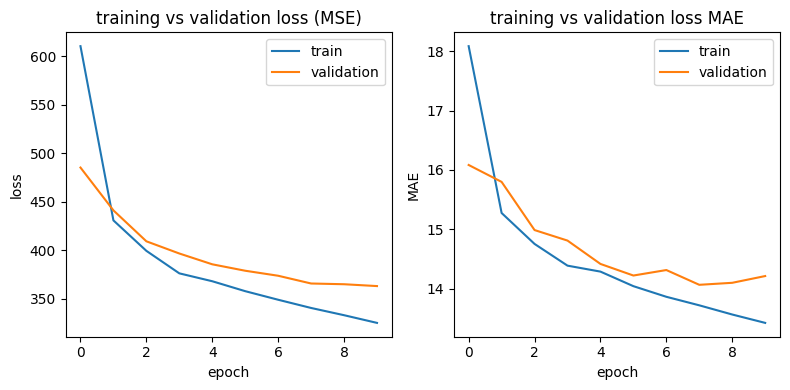

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title("training vs validation loss (MSE)")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='validation')
plt.title("training vs validation loss MAE")
plt.xlabel("epoch"); plt.ylabel("MAE"); plt.legend()
plt.tight_layout()
plt.show()

MAE = 14.21
RMSE = 19.06
R2 = 0.178


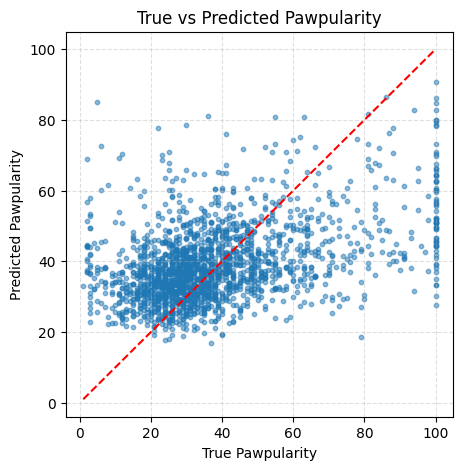

In [9]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in val_ds])

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred) **2))
r2 = r2_score(y_true, y_pred)

print(f"MAE = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R2 = {r2:.3f}")

plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

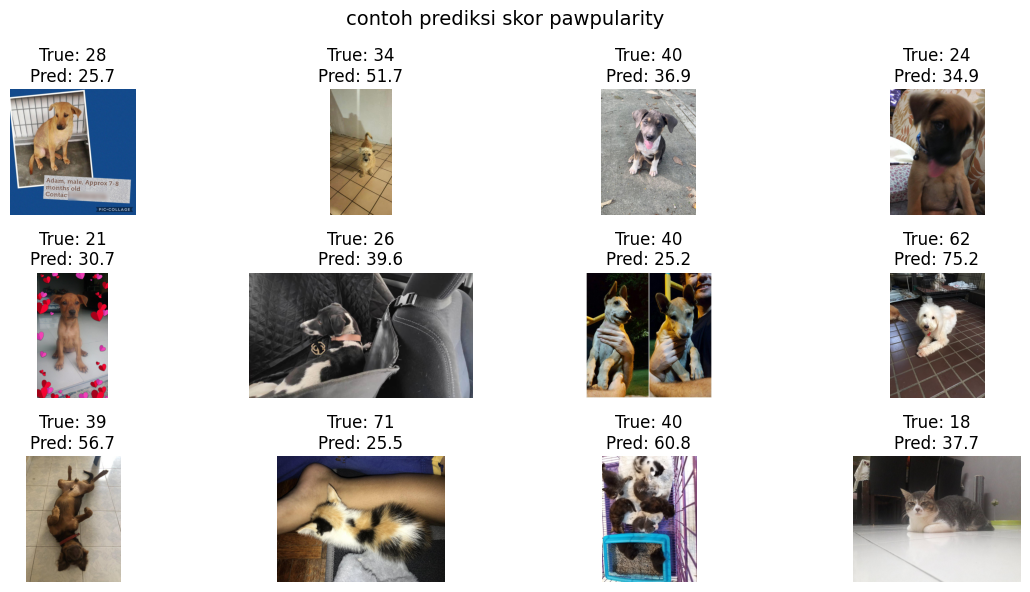

In [10]:
import random
from PIL import Image

sample_rows = val_df.sample(12, random_state=1)

plt.figure(figsize=(12,6))
for i, row in enumerate(sample_rows.itertuples()):
  img = Image.open(row.path)
  pred = model.predict(tf.expand_dims(load_image(row.path, row.Pawpularity) [0], 0), verbose=0).ravel() [0]
  plt.subplot(3,4,i+1)
  plt.imshow(img)
  plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
  plt.axis('off')
plt.suptitle("contoh prediksi skor pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

Silakan unggah foto pribadi atau hewan peliharaan Anda.


Saving WhatsApp Image 2025-10-16 at 19.36.37_6a5f2ce7.jpg to WhatsApp Image 2025-10-16 at 19.36.37_6a5f2ce7.jpg

✅ Foto 'WhatsApp Image 2025-10-16 at 19.36.37_6a5f2ce7.jpg' berhasil diunggah.


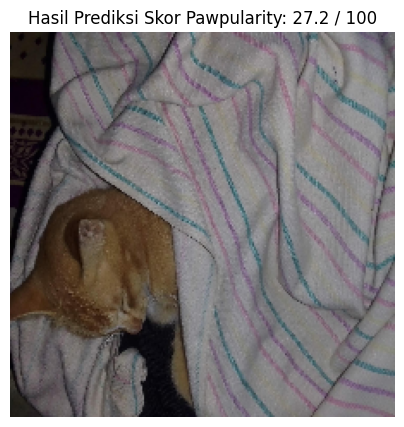

In [13]:
# Import library yang dibutuhkan
from google.colab import files
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# --- FUNGSI UNTUK MEMPROSES DAN MEMPREDIKSI PAWPULARITY ---
def prediksi_pawpularity_foto_pribadi(model_pawpularity):
    """
    Fungsi untuk mengunggah foto, memprosesnya, dan memprediksi skor Pawpularity.
    """
    # 1. Mengunggah file dari komputer Anda
    uploaded = files.upload()

    if not uploaded:
        print("Tidak ada file yang diunggah. Silakan coba lagi.")
        return

    nama_file = list(uploaded.keys())[0]
    print(f"\n✅ Foto '{nama_file}' berhasil diunggah.")

    # 2. Membaca dan memproses gambar
    IMG_SIZE = 224 # Sesuaikan dengan ukuran input model di Praktikum D3 (EfficientNetB0)

    # Baca file gambar
    img = tf.io.read_file(nama_file)
    img = tf.image.decode_jpeg(img, channels=3)

    # Ubah ukuran dan normalisasi gambar
    img_processed = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img_processed = tf.cast(img_processed, tf.float32) / 255.0

    # Tambahkan dimensi batch
    img_batch = tf.expand_dims(img_processed, 0)

    # 3. Lakukan prediksi
    prediksi = model_pawpularity.predict(img_batch, verbose=0)
    skor_pawpularity = prediksi.ravel()[0] # Ambil nilai prediksi

    # 4. Tampilkan hasilnya
    plt.figure(figsize=(5, 5))
    plt.imshow(img_processed)
    plt.title(f"Hasil Prediksi Skor Pawpularity: {skor_pawpularity:.1f} / 100")
    plt.axis('off')
    plt.show()

    # Hapus file yang diunggah
    os.remove(nama_file)

# --- JALANKAN PREDIKSI ---
# Pastikan variabel `model` dari Praktikum D3 sudah ada dan telah dilatih.
# Jika Anda menamainya lain, silakan ganti `model` di bawah ini.
print("Silakan unggah foto pribadi atau hewan peliharaan Anda.")
prediksi_pawpularity_foto_pribadi(model) # Menggunakan variabel 'model' dari D3

#**PENUGASAN**